# 03 — Literature Review with LLMs

# Summarising Scientific Papers with LLMs

This notebook demonstrates how to automate parts of a literature review using:

- **ArXiv API** to fetch paper metadata and abstracts
- **Groq (Llama-3 70B)** to summarise and extract structured information
- **Pandas / Matplotlib** to aggregate and visualise results

clear markdown explanations and thorough code comments are included before every step.

## Objectives
- Use public APIs (arXiv or other databases) to fetch paper metadata.
- Use **Llama-3 70B** to summarise abstracts.
- Extract structured metadata: study type, method, findings.
- Compare and synthesise multiple papers.

**Workflow:**
1. Fetch results by keyword (e.g., *quantum batteries*) into a DataFrame.
2. Summarise single abstract with `chat()`.
3. Batch summarise and extract structured fields (method, sample/setting, main finding).
4. (Optional) Download PDFs for top N and extract crude text.
5. Save a CSV for use in the RAG notebook.

---


🔍 Introduction: why automate literature review?

Researchers face several bottlenecks during literature review:
- **Volume**: thousands of papers, preprints, and conference proceedings.
- **Summarisation**: abstracts and conclusions need to be condensed to core ideas.
- **Synthesis**: comparing findings and methods across studies is time-consuming.

An LLM can help by generating **concise summaries** and extracting **structured fields** (e.g., study type, sample size), enabling quick aggregation and visualisation. However, **human validation is essential** — the model can hallucinate details or misinterpret ambiguous text.

---

### Configure Groq API settings
You need to paste your Groq SPI key here! 

In [ ]:
# --- Groq API Settings ---
# Paste your Groq API key below (between quotes).
# Note: This is NOT a secure way to store secrets if you share the notebook.
import os

os.environ["GROQ_API_KEY"] = ""  # <-- replace with your key (e.g., "gsk_...")
model = "llama-3.3-70b-versatile"  # Select your model https://console.groq.com/docs/models
os.environ["BASE_URL"] = "https://api.groq.com/openai/v1"  # Groq uses an OpenAI-compatible API surface
print("Groq settings configured. (Remember to paste your API key!)")


Groq settings configured. (Remember to paste your API key!)


### Defining of a chat function to use to talk to LLM

In [2]:
# --- Create the OpenAI-compatible client + chat() helper ---
from openai import OpenAI

chat_history = []  # running memory

# Create the client
client = OpenAI(
    api_key=os.environ["GROQ_API_KEY"],
    base_url=os.environ["BASE_URL"],
)

def set_system(prompt: str):
    """Reset chat history to a single system message."""
    global chat_history
    chat_history = [{"role": "system", "content": prompt}]
    return chat_history

def clear_chat():
    """Clear all chat history."""
    global chat_history
    chat_history = []
    return chat_history

def chat(user_input, temperature=0.2, max_turns=8):
    """Send one user turn and get a reply, preserving context.
    - Keeps system prompt + last `max_turns` user/assistant messages.
    """
    chat_history.append({"role": "user", "content": user_input})

    # Keep only the most recent `max_turns` pairs to control context size
    system = chat_history[:1]
    recent = chat_history[-(max_turns*2):] if len(chat_history) > 1 else []
    window = system + recent

    resp = client.chat.completions.create(
        model=model,
        messages=window,
        temperature=temperature,
    )
    reply = resp.choices[0].message.content
    chat_history.append({"role": "assistant", "content": reply})
    return reply

print("Testing API ...")
print()
print("User:")
print("Hello LLM!")
print("LLM:")
print(chat("Hello LLM!"))
print()
print("Client ready. Use chat('...'), set_system('...'), clear_chat().")


Testing API ...

User:
Hello LLM!
LLM:
Hello! It's nice to meet you. Is there something I can help you with or would you like to chat?

Client ready. Use chat('...'), set_system('...'), clear_chat().


In [3]:
# (Optional) One-time installs (run locally if needed)
# %pip install arxiv pandas matplotlib pypdf requests
import pandas as pd
import time
import pathlib, json
from typing import List, Dict, Any

# Matplotlib for simple charts
import matplotlib.pyplot as plt
plt.rcParams.update({"figure.figsize": (6,4)})

DATA_DIR = pathlib.Path("literature_data")
DATA_DIR.mkdir(exist_ok=True)


## Helper functions

In [4]:
import re
import requests
import pandas as pd

def search_arxiv(query: str, max_results: int = 20) -> pd.DataFrame:
    """Basic arXiv search via their Atom feed.
    Note: For production, consider using the `arxiv` Python package.
    """
    base = "http://export.arxiv.org/api/query"
    params = {
        "search_query": query,
        "start": 0,
        "max_results": max_results,
        "sortBy": "relevance",
        "sortOrder": "descending",
    }
    r = requests.get(base, params=params, timeout=30)
    r.raise_for_status()
    text = r.text

    # Crude parsing (avoid external deps). For robust parsing use feedparser.
    entries = text.split("<entry>")[1:]
    rows = []
    for raw in entries:
        def _extract(tag):
            m = re.search(fr"<{tag}>(.*?)</{tag}>", raw, flags=re.S)
            return (m.group(1).strip() if m else "")
        title = re.sub(r"\s+", " ", _extract("title"))
        summary = re.sub(r"\s+", " ", _extract("summary"))
        published = _extract("published").split("T")[0]
        link_m = re.search(r'<link rel="alternate" type="text/html" href="(.*?)"', raw)
        link = link_m.group(1) if link_m else ""
        pdf_m = re.search(r'<link title="pdf" href="(.*?)"', raw)
        pdf = pdf_m.group(1) if pdf_m else ""
        authors = re.findall(r"<name>(.*?)</name>", raw)
        rows.append({
            "title": title,
            "summary": summary,
            "published": published,
            "link": link,
            "pdf": pdf,
            "authors": ", ".join(authors),
        })
    return pd.DataFrame(rows)


In [5]:
def summarise_abstract(abstract: str, topic: str = "general") -> str:
    """Use the global chat() to generate a concise summary of an abstract."""
    set_system("You are a helpful research assistant. Summarise abstracts concisely and faithfully.")
    prompt = f"""Summarise the following scientific abstract in 3-4 sentences.
    Focus on goals, methods, and key findings. Topic: {topic}.

    Abstract:
    {abstract}
    """
    return chat(prompt, temperature=0.1)


In [6]:
def extract_structured_info(abstract: str) -> Dict[str, Any]:
    """Extract {methodology, data/context, finding, limitations} — simple, forgiving version."""
    set_system("You convert abstracts into structured JSON with fields: methodology, data, finding, limitations.")
    prompt = f"""Read the abstract below and return a JSON object with keys:
    methodology, data, finding, limitations. Keep values short and faithful to the text.

    Abstract:
    {abstract}
    """
    raw = chat(prompt, temperature=0.0)

    # Remove Markdown fences if present
    cleaned = raw.strip().removeprefix("```json").removeprefix("```").removesuffix("```").strip()

    try:
        obj = json.loads(cleaned)
        if isinstance(obj, dict):
            # Fill missing keys so nothing stays empty
            for k in ["methodology", "data", "finding", "limitations"]:
                obj[k] = obj.get(k, "").strip() or "Not clearly specified"
            return obj
    except Exception:
        pass

    # Fallback if parsing still fails
    return {
        "methodology": raw,
        "data": "Not clearly specified",
        "finding": "Not clearly specified",
        "limitations": "Not clearly specified",
    }


In [7]:
def download_pdf(url: str, dest_dir: pathlib.Path) -> pathlib.Path:
    """Download a PDF to dest_dir, return path. Simple and naive."""
    fn = dest_dir / (url.rstrip("/").split("/")[-1] + ".pdf" if not url.endswith(".pdf") else url.split("/")[-1])
    with requests.get(url, stream=True, timeout=60) as r:
        r.raise_for_status()
        with open(fn, "wb") as f:
            for chunk in r.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)
    return fn


In [8]:
from pypdf import PdfReader

def extract_pdf_text(pdf_path: pathlib.Path, max_pages: int = 10) -> str:
    """Crude text extraction using pypdf (first max_pages)."""
    text = []
    reader = PdfReader(str(pdf_path))
    for i, page in enumerate(reader.pages):
        if i >= max_pages:
            break
        try:
            text.append(page.extract_text() or "")
        except Exception:
            pass
    return "\n".join(text)


## 1) Search arXiv by keyword

## 2. 🔗 Fetch data via ArXiv API

We will query the **ArXiv** API for works matching a keyword (e.g., *"quantum batteries"*). ArXiv provides abstracts and metadata like publication year.

⚠️ **Network note**: This requires internet access. If running on an offline HPC, pre-fetch and cache JSON responses.


In [9]:
query = "quantum batteries"  # change freely
df = search_arxiv(query, max_results=10)
print(f"Fetched {len(df)} results for query: {query!r}")
df.head(5)


Fetched 10 results for query: 'quantum batteries'


,title,summary,published,link,pdf,authors
0,Local-projective-measurement-enhanced quantum ...,Quantum batteries have significant potential a...,2024-05-06,,http://arxiv.org/pdf/2405.03093v1,"Tinggui Zhang, Hong Yang, Shao-Ming Fei"
1,Entanglement and energy transportation in the ...,Quantum battery exploits the principle of quan...,2025-02-11,,http://arxiv.org/pdf/2502.07513v1,"Fan Liu, Hui-Yu Yang, Shuai-Li Wang, Jun-Zhong..."
2,High-performance Kerr quantum battery,We propose and investigate the performance of ...,2023-05-04,,http://arxiv.org/pdf/2305.03202v2,"Muhammad Shoufie Ukhtary, Ahmad R. T. Nugraha,..."
3,Dual-cavity controllable quantum battery,With the rapid development of quantum science ...,2024-06-10,,http://arxiv.org/pdf/2406.06383v2,"Dayang Zhang, Shuangquan Ma, Yunxiu Jiang, You..."
4,Optimizing quantum battery performance by redu...,Quantum batteries have emerged as promising de...,2025-05-12,,http://arxiv.org/pdf/2505.08029v1,"Rohit Kumar Shukla, Rajiv Kumar, Ujjwal Sen, S..."


## 2) Summarise a single abstract

🧩 Summarise a single abstract with Llama-3 70B

Now we connect to the **Groq API** (OpenAI-compatible) and ask **Llama-3 70B** to produce a concise summary of one abstract.

⚠️ Remember, if you restart the kernel, you must re-set your API key.

In [10]:

abstract = df.loc[0, "summary"]
clear_chat()  # start fresh
short_sum = summarise_abstract(abstract, topic=query)
structs = extract_structured_info(abstract)
print(short_sum)
print(structs)


Researchers investigated methods to enhance the capacity of quantum batteries, a crucial aspect for their potential applications. They focused on bipartite quantum systems and explored the effect of local projective measurements on a subsystem of the quantum state. Using two-qubit Bell-diagonal states and X-type states as examples, the study found that local projective measurements can improve the quantum battery capacity for both the whole system and a subsystem. The theoretical findings aim to provide guidance for the experimental development of quantum batteries with improved capacity.
{'methodology': 'Local projective measurements on bipartite quantum systems', 'data': 'Two-qubit Bell-diagonal and X-type states', 'finding': 'Local measurements can improve quantum battery capacity', 'limitations': 'Theoretical analysis, experimental development needed'}


## 3) Batch summarisation + structured extraction

Loop over all abstracts to create a **summary_llm** and **structured** columns.

**What this cell does:**
- Iterates over the rows.
- Calls the LLM for a 3-4 sentence summary.
- Stores the result in a new `summary` column.
- creates a jason output that contains: "methodology":, "data", "finding" and "limitations".
-  Stores the result in a new `structured` column.

In [11]:
summaries = []
structs = []
for i, row in df.iterrows():
    clear_chat()
    s = summarise_abstract(row["summary"], topic=query)
    summaries.append(s)

    clear_chat()
    st = extract_structured_info(row["summary"])
    structs.append(st)
    time.sleep(0.2)  # be gentle

    print(f"Processed {i}/{len(df)}")


df["summary_llm"] = summaries
df["structured"] = structs




Processed 0/10
Processed 1/10
Processed 2/10
Processed 3/10
Processed 4/10
Processed 5/10
Processed 6/10
Processed 7/10
Processed 8/10
Processed 9/10


In [12]:
df.head(3)

,title,summary,published,link,pdf,authors,summary_llm,structured
0,Local-projective-measurement-enhanced quantum ...,Quantum batteries have significant potential a...,2024-05-06,,http://arxiv.org/pdf/2405.03093v1,"Tinggui Zhang, Hong Yang, Shao-Ming Fei",This study explores methods to enhance the cap...,{'methodology': 'Local projective measurements...
1,Entanglement and energy transportation in the ...,Quantum battery exploits the principle of quan...,2025-02-11,,http://arxiv.org/pdf/2502.07513v1,"Fan Liu, Hui-Yu Yang, Shuai-Li Wang, Jun-Zhong...",Researchers studied the central-spin quantum b...,"{'methodology': 'Invariant subspace method', '..."
2,High-performance Kerr quantum battery,We propose and investigate the performance of ...,2023-05-04,,http://arxiv.org/pdf/2305.03202v2,"Muhammad Shoufie Ukhtary, Ahmad R. T. Nugraha,...","Researchers propose a ""Kerr quantum battery"" c...",{'methodology': 'Proposed and investigated a h...


## 4) Quick counts / simple visualisation

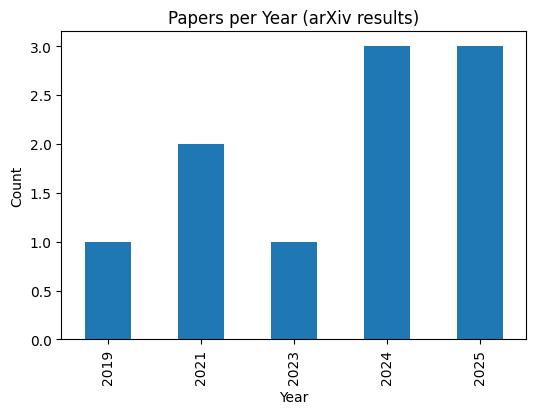

In [13]:
# Count by year (based on 'published' YYYY-MM-DD -> YYYY)
years = df["published"].str.slice(0,4)
counts = years.value_counts().sort_index()
counts.plot(kind="bar")
plt.title("Papers per Year (arXiv results)")
plt.xlabel("Year")
plt.ylabel("Count")
plt.show()



## 5) Finding most relevant papers and download PDFs and extract crude text

In [14]:
import json, time, textwrap

def select_and_fetch_pdfs(
    df: pd.DataFrame,
    question: str,
    k: int = 3,
    max_pages: int = 8,
    sleep_s: float = 0.5,
) -> pd.DataFrame:
    """
    Use the LLM to select the k most relevant entries in df for the research question,
    download their PDFs, extract crude text, and return a df_top with added columns:
      - pdf_file
      - crude_text

    Requires: chat(), set_system(), clear_chat(), download_pdf(), extract_pdf_text(),
              DATA_DIR (Path) to exist.
    """
    assert {"title", "summary", "link", "pdf"}.issubset(df.columns), "df must have title, summary, link, pdf"

    # 1) Prepare a short list for the model (index, title, short summary)
    items = []
    for i, row in df.iterrows():
        t = str(row["title"]).strip()
        s = str(row["summary"]).strip().replace("\n", " ")
        s = (s[:300] + "…") if len(s) > 300 else s  # keep prompt small
        items.append({"idx": int(i), "title": t, "summary": s})

    shortlist = json.dumps(items, ensure_ascii=False)

    # 2) Ask the model to return ONLY JSON with a list of the best indices
    clear_chat()
    set_system("Return ONLY valid JSON. No extra text or code fences.")
    prompt = f"""
You are selecting the most relevant papers for a research question.

QUESTION:
{question}

Here is a list of candidates (index, title, summary):
{shortlist}

Return ONLY JSON with this exact shape:
{{"best": [idx1, idx2, ...]}}

Rules:
- Choose exactly {k} unique indices.
- Prefer titles/summaries that directly address the question.
- Do not add explanations or extra keys.
"""
    raw = chat(textwrap.dedent(prompt).strip(), temperature=0.0)

    # 3) Parse indices; simple fence stripping just in case
    cleaned = raw.strip().removeprefix("```json").removeprefix("```").removesuffix("```").strip()
    try:
        obj = json.loads(cleaned)
        idxs = list(dict.fromkeys([int(x) for x in obj.get("best", [])]))[:k]  # unique, max k
    except Exception:
        idxs = list(df.index)[:k]  # fallback: take head(k)

    if len(idxs) < k:
        # pad with head(k) if model returned fewer than k
        head_idxs = [i for i in df.index[:k] if i not in idxs]
        idxs = (idxs + head_idxs)[:k]

    # 4) Download PDFs and extract text
    pdf_dir = DATA_DIR / "full_texts"
    pdf_dir.mkdir(parents=True, exist_ok=True)

    rows = []
    for i in idxs:
        row = df.loc[i]
        url = row["pdf"] or row["link"]
        pdf_name, crude = "", ""
        if url:
            try:
                path = download_pdf(url, pdf_dir)
                pdf_name = path.name
                crude = extract_pdf_text(path, max_pages=max_pages)
            except Exception as e:
                print(f"Failed for idx {i}: {e}")
        rows.append({**row.to_dict(), "pdf_file": pdf_name, "crude_text": crude})
        time.sleep(sleep_s)

    df_top = pd.DataFrame(rows).reset_index(drop=True)
    return df_top


In [15]:
question = "What experimental or theoretical methods advance quantum batteries most effectively?"
df_top = select_and_fetch_pdfs(df, question, k=3, max_pages=8)
df_top.head(3)


,title,summary,published,link,pdf,authors,summary_llm,structured,pdf_file,crude_text
0,Local-projective-measurement-enhanced quantum ...,Quantum batteries have significant potential a...,2024-05-06,,http://arxiv.org/pdf/2405.03093v1,"Tinggui Zhang, Hong Yang, Shao-Ming Fei",This study explores methods to enhance the cap...,{'methodology': 'Local projective measurements...,2405.03093v1.pdf,arXiv:2405.03093v1 [quant-ph] 6 May 2024\nLo...
1,Optimizing quantum battery performance by redu...,Quantum batteries have emerged as promising de...,2025-05-12,,http://arxiv.org/pdf/2505.08029v1,"Rohit Kumar Shukla, Rajiv Kumar, Ujjwal Sen, S...",Researchers investigated the dynamics of quant...,{'methodology': 'Investigating interplay betwe...,2505.08029v1.pdf,arXiv:2505.08029v1 [quant-ph] 12 May 2025\nO...
2,Efficient charging of multiple open quantum ba...,We explore a protocol that efficiently charges...,2024-10-25,,http://arxiv.org/pdf/2410.19303v1,"Josephine Dias, Hui Wang, Kae Nemoto, Franco N...",This study aims to develop an efficient protoc...,{'methodology': 'protocol using collective cou...,2410.19303v1.pdf,Efficient charging of multiple open quantum ba...


### Other Methods for Selecting the Top-K Most Relevant Abstracts

#### Embedding-Based Similarity (Vector Search)
Instead of asking the LLM directly, each abstract and the research question can be converted into **vector embeddings** using a sentence or document encoder (e.g., *Sentence-Transformers*, *OpenAI text-embedding-3-small*, or Groq’s embedding models*).  
Relevance is then computed via **cosine similarity**, and the top-K most similar abstracts are selected.

- **Pros:** Fast, reproducible, and explainable.  
- **Cons:** Requires an embedding model.  
- **Typical use:** The foundation of most RAG (Retrieval-Augmented Generation) systems.

---

#### Structured Multi-Criteria Scoring
Another approach is to define **specific evaluation criteria** and let the LLM (or a human reviewer) score each abstract numerically.  
For example, score each paper from **1–5** on:
- *Method novelty*  
- *Data similarity to your question*  
- *Domain alignment*  
- *Practical applicability*

You can then compute a weighted average or composite score to select the top-K.  
This method is especially useful for **research evaluation**, **grant triaging**, or **systematic reviews**, where transparency and criteria consistency matter.


## 6) Save CSV for RAG notebook

In [16]:
out_csv = DATA_DIR / "literature_corpus.csv"
df.to_csv(out_csv, index=False)
print("Saved:", out_csv.resolve())

out_csv = DATA_DIR / "literature_corpus_top.csv"
df_top.to_csv(out_csv, index=False)
print("Saved:", out_csv.resolve())


Saved: C:\code\llm_tutorial\literature_data\literature_corpus.csv
Saved: C:\code\llm_tutorial\literature_data\literature_corpus_top.csv


### Wrap-up
- You fetched paper metadata into a DataFrame.
- You used `chat()` with a resettable memory for summarisation and structured extraction.
- You (optionally) downloaded PDFs and extracted crude text.
- You saved `literature_corpus.csv` for the next RAG notebook.
